In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import missingno as mis
import matplotlib.pyplot as plt
import gc

In [2]:
import seaborn as sns
def plotHeatMap(df, size=(16,9),an=True):
    plt.figure(figsize=size)
    cmap = plt.cm.magma
    sns.heatmap(df.corr(),cmap=cmap,linewidths=0.1,vmax=1, linecolor="white", square=True,annot=an)
    plt.show()

In [3]:
train = pd.read_csv('../Data/train_data.csv')
test = pd.read_csv('../Data/test_data.csv')

In [4]:
row, col = train.shape
print(str(row) + ' ' + str(col))

169307 43


In [5]:
train.isnull().sum()

connection_id    0
cont_1           0
cont_2           0
cont_3           0
cont_4           0
cont_5           0
cont_6           0
cont_7           0
cont_8           0
cont_9           0
cont_10          0
cont_11          0
cont_12          0
cont_13          0
cont_14          0
cont_15          0
cont_16          0
cont_17          0
cont_18          0
cat_1            0
cat_2            0
cat_3            0
cat_4            0
cat_5            0
cat_6            0
cat_7            0
cat_8            0
cat_9            0
cat_10           0
cat_11           0
cat_12           0
cat_13           0
cat_14           0
cat_15           0
cat_16           0
cat_17           0
cat_18           0
cat_19           0
cat_20           0
cat_21           0
cat_22           0
cat_23           0
target           0
dtype: int64

In [6]:
features = [ x for x in train.columns if x not in ['connection_id', 'target']]

In [7]:
targetValues = train["target"].value_counts().index.values
numberOfTarget = train["target"].value_counts().values

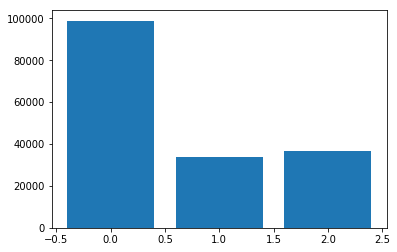

In [8]:
plt.bar(targetValues,numberOfTarget)
plt.show()

The classes are imbalanced nearly 0 = 1+2

In [9]:
from collections import Counter
Counter(train.dtypes.values)

Counter({dtype('int64'): 27, dtype('float64'): 15, dtype('O'): 1})

In [10]:
train_float = train[features].select_dtypes(include=['float64'])
train_int = train[features].select_dtypes(include=['int64'])


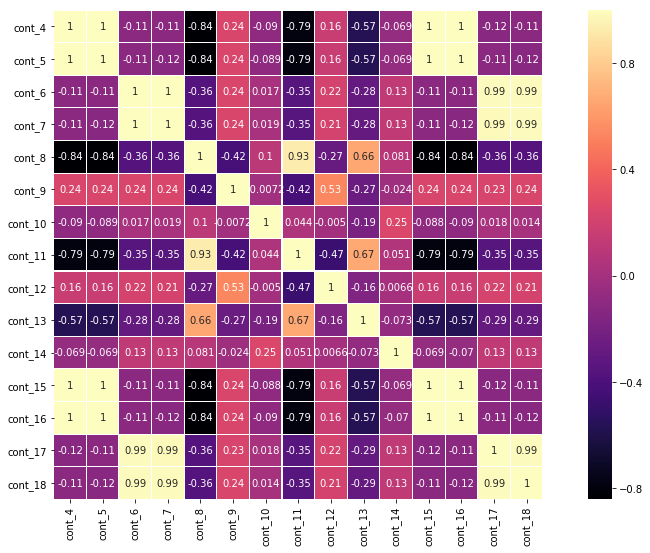

In [11]:
plotHeatMap(train_float)

As we can see the data is highly corealted. Dimensionality reduction can be done for float value coloumns. But something seems fishy in data

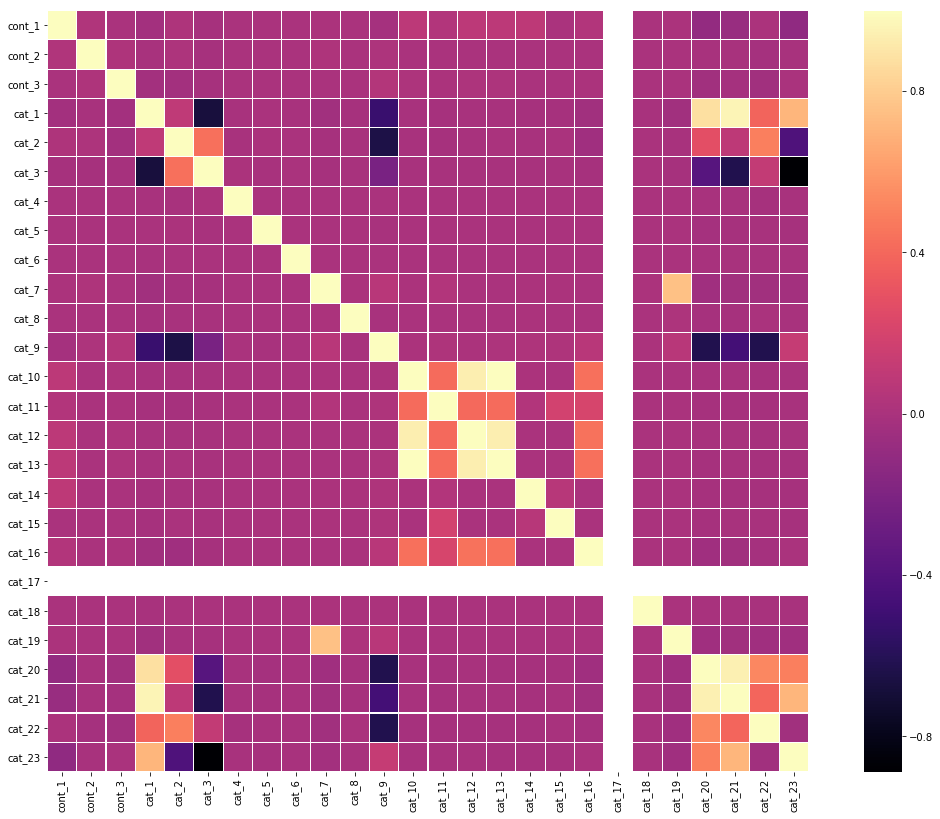

In [12]:
plotHeatMap(train_int,size=(20,14),an=False)

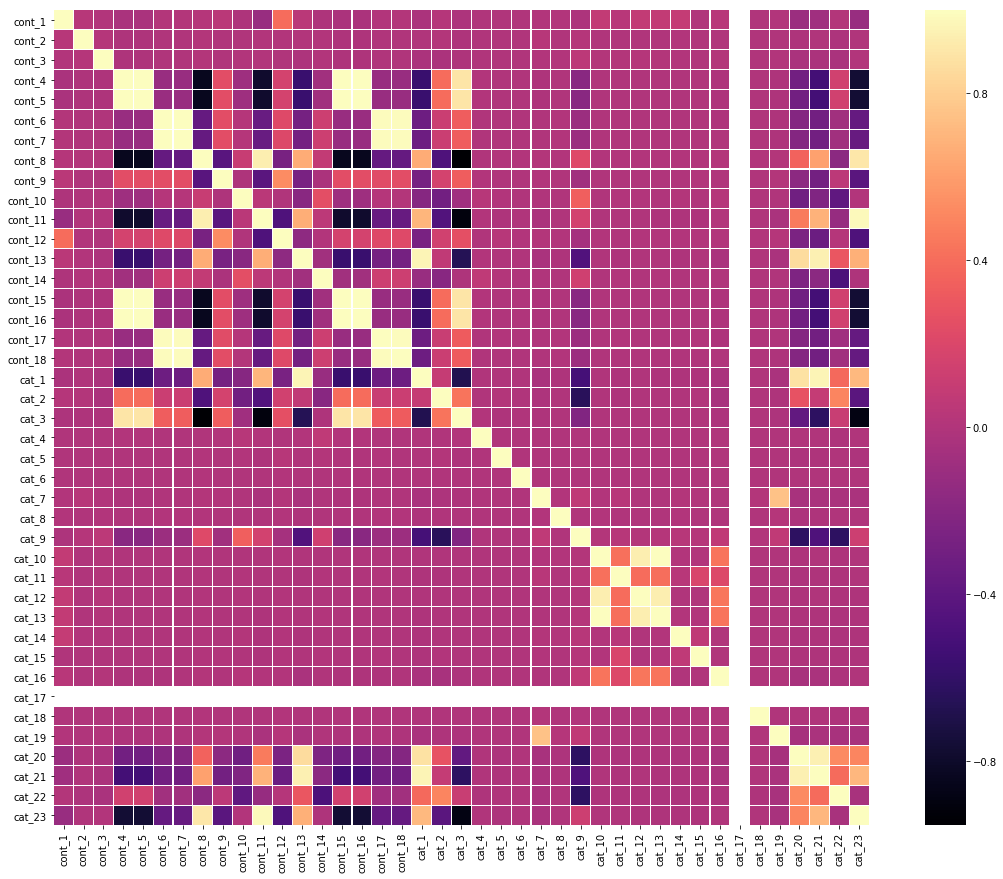

In [13]:
plotHeatMap(train[features],size=(20,15),an=False)

### It is seen that the continous values had high corelation and the cat_19 - cat _23 had high coreleation with every value. Now let us see the mutual importance of the data with target

In [14]:
def aggregate(X,Y):
    A = [(x,y) for x,y in zip(X,Y)]
    df = pd.DataFrame(A)
    df.columns = ['Name', 'Importance']
    df=df.sort_values(['Importance'])
    df
    return df

In [15]:
def horiBar(Name,Importance):
    df=aggregate(Name, Importance)
    sns.barplot(df['Importance'],df['Name'])
    plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mif = mutual_info_classif(train_float,train['target'],n_neighbors=3, random_state=17)
mit = mutual_info_classif(train_int,train['target'],n_neighbors=3, random_state=17 )
miall = mutual_info_classif(train[features],train['target'],n_neighbors=3, random_state=17)

In [ ]:
plt.figure(figsize=(16,5))
plt.title('Mutual information of Float type')
horiBar(train_float.columns,mif)

In [ ]:
plt.figure(figsize=(16,10))
plt.title('Mutual information of int type')
horiBar(train_int.columns, mit)

In [ ]:
plt.figure(figsize=(16,20))
plt.title('Mutual information of every feature')
horiBar(features,miall)

#### In the above all mutual info grph we can see that most of the features have nearly zero mutual realtion with the data. Also mostly continuous values have hih mutual realtion with the data.
The highest point are vat 29 and cont 2

### Binary Coloumn searching

In [ ]:
binaryColoums = [x for x in features if len(train[x].value_counts().index.values) == 2]

In [123]:
print(binaryColoums)

['cat_4', 'cat_6', 'cat_8', 'cat_9', 'cat_11', 'cat_18', 'cat_19']


In [124]:
# I am thinking that having diffrent type of colowumn name feature dictnory
featureNameIndex = dict()
featureNameIndex['all'] = features
featureNameIndex['binary'] = binaryColoums
featureNameIndex['float64'] = train_float.columns
featureNameIndex['int64'] = train_int.columns
featureNameIndex['cat'] = [x for x in train.columns if 'cat' in x]
featureNameIndex['cont'] = [x for x in train.columns if 'cont' in x]

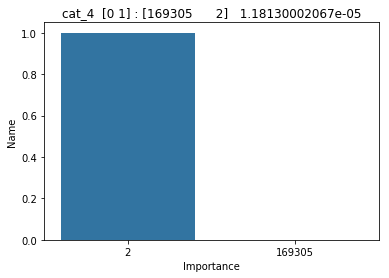

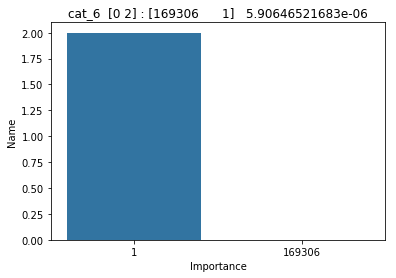

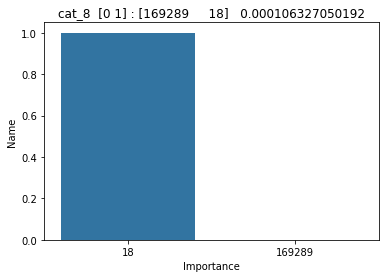

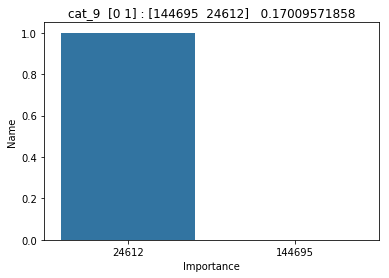

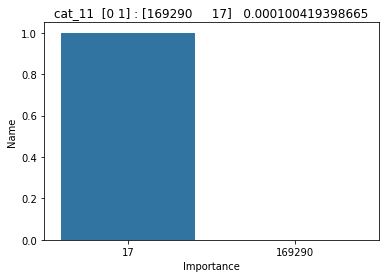

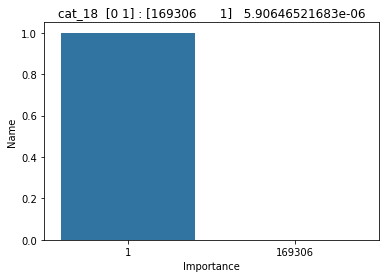

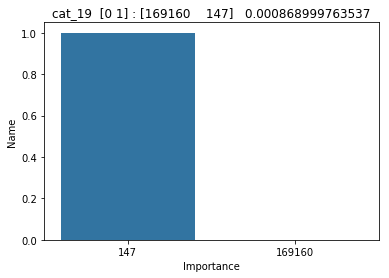

In [125]:
for i in featureNameIndex['binary']:
    plt.title(i + '  ' + str(train[i].value_counts().index.values) + ' : ' + str(train[i].value_counts().values) + '   ' +str(train[i].value_counts().values[1]/train[i].value_counts().values[0]) )
    horiBar(train[i].value_counts().index.values,train[i].value_counts().values)

## We can see that the binary feature of the cat9 have some values for 1. Also we can note that it have some effet on mutual realtion also. Since most of the data were unbalced in the binary feature. Most of them biashed toward the 0. So i think these features can be discarded. 
###  Futher test will be performed on all kind of feature

In [126]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=400, max_depth=9, min_samples_leaf=50, max_features=0.2, n_jobs=-1, random_state=2002)
rf.fit(train[featureNameIndex['all']], train['target'])
print("----- Training Done -----")

----- Training Done -----


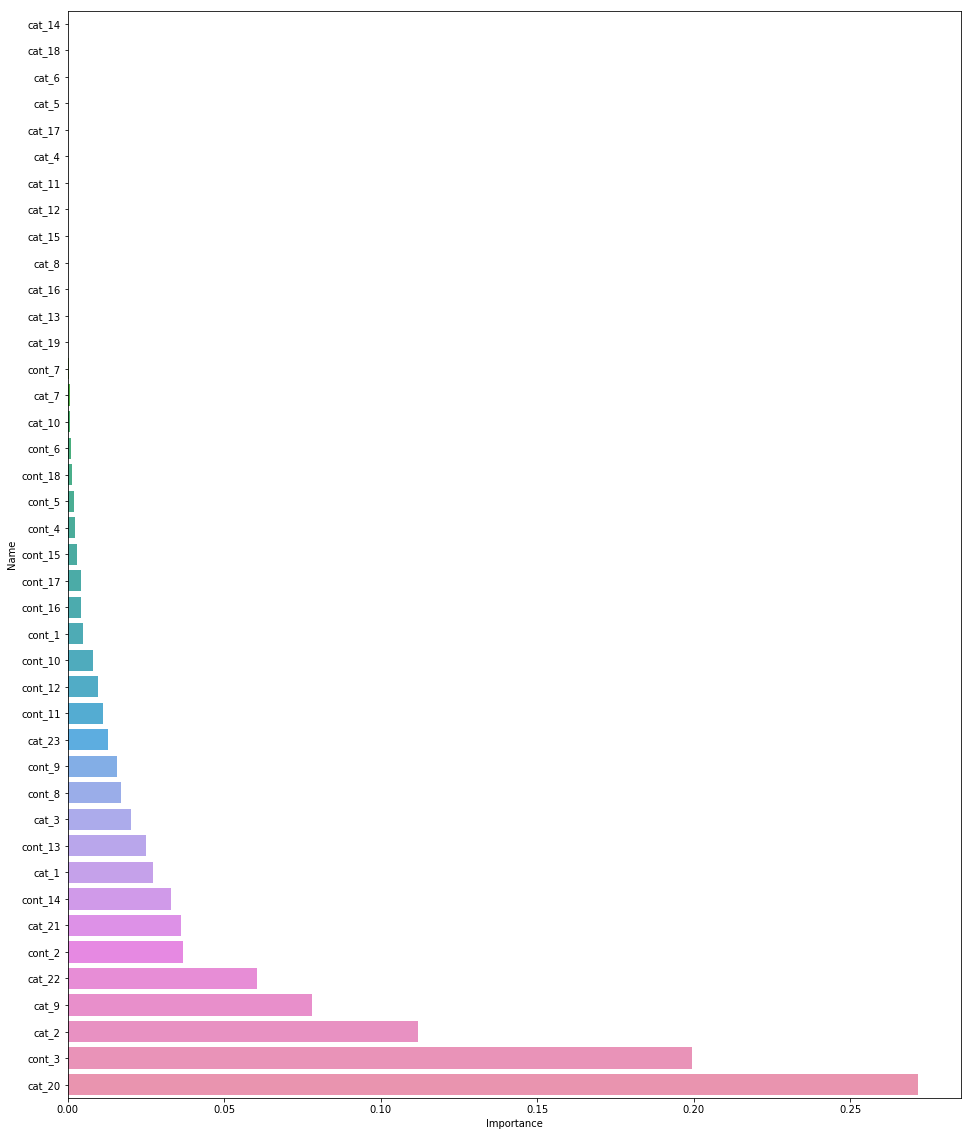

In [127]:
plt.figure(figsize=(16,20))
horiBar(featureNameIndex['all'],rf.feature_importances_)

In [223]:
featureNameIndex['dropCat'] = ['cat_4','cat_5','cat_6','cat_7','cat_8','cat_11','cat_12','cat_15','cat_17','cat_18']

In [224]:
train = train.drop(featureNameIndex['dropCat'],axis=1)
test = test.drop(featureNameIndex['dropCat'],axis=1)
featureNameIndex['binary'] = [x for x in featureNameIndex['binary'] if x not in featureNameIndex['dropCat']]
featureNameIndex['int64'] = [x for x in featureNameIndex['int64'] if x not in featureNameIndex['dropCat']]
featureNameIndex['float64'] = [x for x in featureNameIndex['float64'] if x not in featureNameIndex['dropCat']]
featureNameIndex['cat'] = [x for x in featureNameIndex['cat'] if x not in featureNameIndex['dropCat']]
featureNameIndex['cont'] = [x for x in featureNameIndex['cont'] if x not in featureNameIndex['dropCat']]
featureNameIndex['all'] = [x for x in features if x not in featureNameIndex['dropCat']]

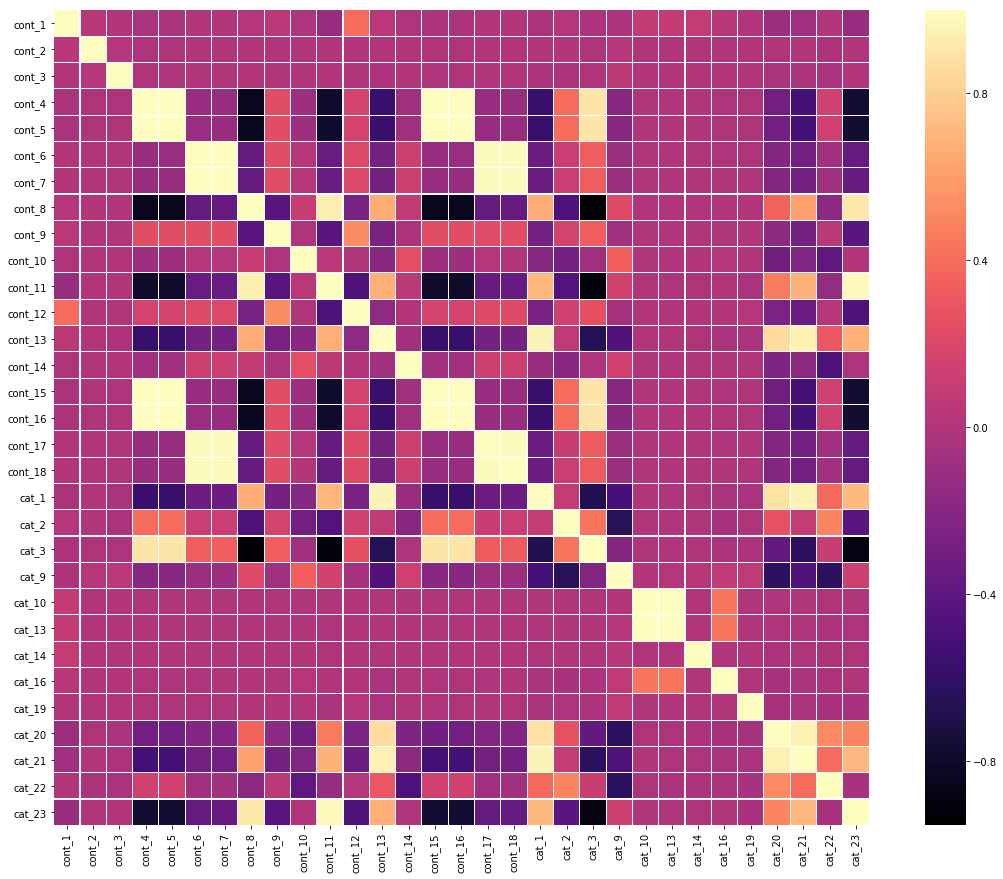

In [225]:
plotHeatMap(train[featureNameIndex['all']],size=(20,15),an=False)

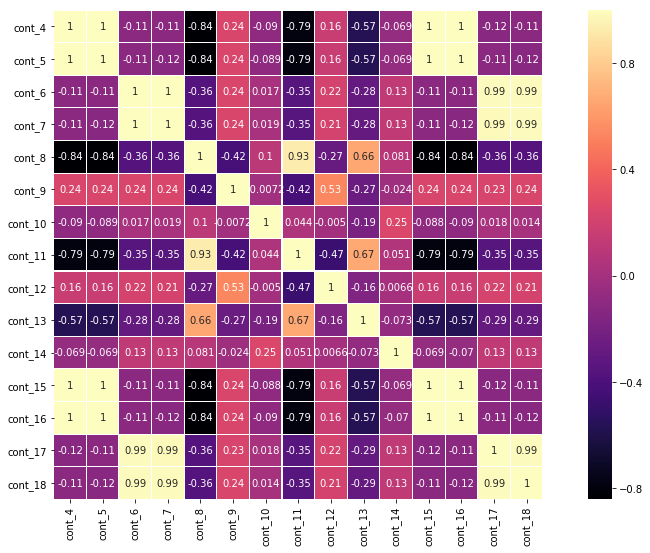

In [226]:
plotHeatMap(train[featureNameIndex['float64']])

In [227]:
train['cont_45_Min'] = [min(i,j) for i,j in zip(train['cont_4'],train['cont_5'])]
train['cont_45_Max'] = [max(i,j) for i,j in zip(train['cont_4'],train['cont_5'])]
test['cont_45_Min'] = [min(i,j) for i,j in zip(test['cont_4'],test['cont_5'])]

In [228]:
train[['cont_45_Min','cont_45_Max','target']].corr()

,cont_45_Min,cont_45_Max,target
cont_45_Min,1.000000,0.998544,-0.051073
cont_45_Max,0.998544,1.000000,-0.050831
target,-0.051073,-0.050831,1.000000


### As we can see the min has most corr with target selecting min

In [229]:
train = train.drop(['cont_4','cont_5','cont_45_Max'],axis=1)
test = test.drop(['cont_4','cont_5'],axis=1)

In [230]:
featureNameIndex['all'] = [x for x in featureNameIndex['all'] if x not in ['cont_4','cont_5','cont_45_Max','cont_45_min']]
featureNameIndex['all'].append('cont_45_Min')


In [233]:

# plotHeatMap(train[featureNameIndex['all']],an=False, size=(20,15trainPCA))

In [234]:
from sklearn.decomposition import PCA

In [235]:
pca = PCA(n_components=2,svd_solver="full",random_state=20540727)

In [236]:
pca.fit(train[featureNameIndex['all']])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=20540727,
  svd_solver='full', tol=0.0, whiten=False)

In [237]:
trainPCA = pca.transform(train[featureNameIndex['all']])
testPCA = pca.transform(test[featureNameIndex['all']])

In [238]:
sum(pca.explained_variance_ratio_)

0.99982060650757587

In [239]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [240]:
feature_names = [x for x in train.columns if x not in ['connection_id','target']]
target = train['target']

In [241]:
X_train, X_valid, y_train, y_valid = train_test_split(trainPCA, target, train_size = 0.7, stratify = target, random_state = 2017)

/home/ab/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [242]:
from sklearn.metrics import accuracy_score
def multAcc(pred, dtrain):
    label = dtrain.get_label()
    acc = accuracy_score(label, pred)
    return 'maccuracy', acc

In [251]:
params = {}
params['objective'] = 'multi:softmax'
params['eta'] = 0.02
params['silent'] = True
params['max_depth'] = 6
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9
params['nthread']=-1
params['num_class'] = 2

In [252]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
dtest = xgb.DMatrix(data=testPCA)
watchlist = [(dtrain, 'train'),(dvalid, 'eval')]

In [256]:
gc.collect()
clf1 = xgb.train(params, dtrain, 1000, watchlist, maximize=True, verbose_eval=25, early_stopping_rounds=400, feval=multAcc)

[0]	train-maccuracy:0.779013	eval-maccuracy:0.77932
Multiple eval metrics have been passed: 'eval-maccuracy' will be used for early stopping.

Will train until eval-maccuracy hasn't improved in 400 rounds.
[25]	train-maccuracy:0.778524	eval-maccuracy:0.778985
[50]	train-maccuracy:0.778617	eval-maccuracy:0.779064
[75]	train-maccuracy:0.77887	eval-maccuracy:0.779123
[100]	train-maccuracy:0.778836	eval-maccuracy:0.779162
[125]	train-maccuracy:0.778853	eval-maccuracy:0.779162
[150]	train-maccuracy:0.779191	eval-maccuracy:0.779477
[175]	train-maccuracy:0.779486	eval-maccuracy:0.779694
[200]	train-maccuracy:0.779553	eval-maccuracy:0.779694
[225]	train-maccuracy:0.779545	eval-maccuracy:0.779733
[250]	train-maccuracy:0.779655	eval-maccuracy:0.779871
[275]	train-maccuracy:0.779798	eval-maccuracy:0.77993
[300]	train-maccuracy:0.779866	eval-maccuracy:0.77995
[325]	train-maccuracy:0.779883	eval-maccuracy:0.77993
[350]	train-maccuracy:0.780001	eval-maccuracy:0.77995
[375]	train-maccuracy:0.780169	e

In [261]:
pred = clf1.predict(dtest)

In [263]:
## make submission
sub = pd.read_csv('../Data/sample_submission.csv')
sub['target'] = pred
sub['target'] = sub['target'].astype(int)
sub.to_csv('PCA_XGB_I_Submission_0_78056.csv', index=False)

In [ ]:
pred

In [ ]:
import pickle
pickle.dump(open('xgbTrain1000_400.dat','w'),clf1)